<a href="https://colab.research.google.com/github/matteoanelli/Dog_breed_classification/blob/master/dog_app.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

**This notebook is inspired by a project of the Machine Learning Engineer Nanodegre program of Udacity.**

### Description
--- 

The project consists of building a CNN-based approach to create a dog breed identification app. Additionally, if the input image consists of a human picture the application will suggest the most resembling breed. If something else will be used as input the app will raise an error.

### App Blocks
--- 

The final application consists of 3 main blocks. A human detector that classifies if the input image is a human. A dog detector that classifies if the image is a dog. Finally, a model that assign the most resembling breed to the image.


### Implementation choices
---

  * Human detector --> Pretrained PyTorch model ([facenet-pytorch](https://github.com/timesler/facenet-pytorch.git)).
  * Dog detector  --> Pre-trained VGG-16 Model trained on [ImageNet](http://www.image-net.org/)
  * Breed classifier --> PyTorch custom model

### Datasets
---
  * [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip) that consist in dog images.
  * [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip) that consist in human faces. 

> **Note: The notebook will automatically download the datasets at runtime.**

### Example of the output
---
![Sample Dog Output](https://github.com/matteoanelli/Dog_breed_classification/blob/master/images/sample_dog_output.png?raw=1)

---
### Table of content

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Application
* [Step 6](#step6): Final tests


In [1]:
!pip install facenet_pytorch

In [2]:
import torch
import numpy as np

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


In [4]:
# Set to True if we want to skip the training processes.
skip_training = False

<a id='step0'></a>
## Step 0: Import Datasets


In [5]:
# Import datasets
import os
if not os.path.isdir("./dogImages/"):
  !wget -q -O tmp.zip https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip && unzip tmp.zip && rm -f tmp.zip
else:
  print("DogImages data already downloaded")

if not os.path.isdir("./lfw"):
  !wget -q -O tmp.zip https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip && unzip tmp.zip && rm -f tmp.zip
else:
  print("Human faces data already downloaded")


DogImages data already downloaded
Human faces data already downloaded


In [6]:
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("./lfw/*/*"))
dog_files = np.array(glob("./dogImages/*/*/*"))

# print number of images in each dataset
print('There are {} total human images.'.format(len(human_files)))
print('There are {} total dog images.'.format(len(dog_files)))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

### Write a Human Face Detector

In [7]:
# returns "True" if face is detected in image stored at img_path
import matplotlib.image as img

def face_detector(model, img_path):
    """
        Function that classify if the input image is a human. It does it using 
        a model tha detect faces.
    Args:
        model:
            Model used to detect the human.
        img_path (str):
            Path of the image to classify
            
    Returns:
        classification (Bool):
            True if the image is a human picture, False otherwise.   

    """
    # Read the image form path
    image = img.imread(img_path)

    # Detect face
    face, prob = model(image, return_prob=True)

    return True if face is not None else False
      

### Test the Human Face Detector



In [8]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from facenet_pytorch import MTCNN

# Initialaize face detector
mtcnn = MTCNN(device=device)
# Number of first tested images
n_test_images = 100

human_files_short = human_files[:n_test_images]
dog_files_short = dog_files[:n_test_images]

print("Processing human images")
human = [1 for i in tqdm(range(n_test_images)) if 
         face_detector(mtcnn, human_files_short[i])]

print("Processing dog images")
dog = [1 for i in tqdm(range(n_test_images)) if 
       face_detector(mtcnn, dog_files_short[i])]
        
print('\n The percentage of the first {} images in human_files is: {}%'.format(
    n_test_images, sum(human)/n_test_images * 100))
print('The percentage of the first {} images in dog_files is: {}%'.format(
    n_test_images, sum(dog)/n_test_images * 100))



  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
  4%|▍         | 4/100 [00:00<00:02, 35.84it/s]

Processing human images


  4%|▍         | 4/100 [00:00<00:03, 31.51it/s]

Processing dog images


100%|██████████| 100/100 [00:05<00:00, 17.45it/s]


 The percentage of the first 100 images in human_files is: 100.0%
The percentage of the first 100 images in dog_files is: 26.0%


---
<a id='step2'></a>
## Step 2: Detect Dogs

Pre-trained VGG-16 Model on ImageNet [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

The [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a) shows that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268.



In [9]:
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True).to(device)
VGG16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Dog prediction function

In [10]:
from PIL import Image
import torchvision.transforms as T

def VGG16_predict(net, img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class.
    
    Args:
        net (nn.Module): 
          The VGG16 model used to predict.
        img_path (str): 
          path to an image.
        
    Returns:
        Index corresponding to VGG-16 model's prediction.
    '''
    
    # Create the transformer to input a format accepted from the VGG16
    transform = T.Compose([
        T.Resize(256), 
        T.CenterCrop(224),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # TODO fix normalization
    
    # Load and trasnform input image from path
    img = transform(Image.open(img_path).convert('RGB')).to(device)

    
    
    # Prepare the network
    net.eval()
    with torch.no_grad():
        out = net(img.unsqueeze(0))
    
    
    return int(torch.argmax(out)) # predicted class index

In [11]:
import random
# Test the output of VGG16 predict
def test_VGG16_predict(net):
       
    image = human_files[random.randint(0,100)]
    out = VGG16_predict(net,image)
    assert 0 <= out <= 999, f'The output is not valid: {out}'
    
    print('Success')

test_VGG16_predict(VGG16)

Success


In [12]:
def dog_detector(model, img_path):
    """
        Function that classify if the input image is a dog.
    Args:
        model:
            Model used to detect the human.
        img_path (str):
            Path of the image to classify
            
    Returns:
        classification (Bool):
            True if the image is a dog picture, False otherwise.   

    """
    # Detect dog
    return False if 151 <= VGG16_predict(model, img_path) >= 268 else True

      

### Test the Dog Detector



In [13]:

human = [1 for i in range(n_test_images) if dog_detector(VGG16, 
                                                         human_files_short[i])]
dog = [1 for i in range(n_test_images) if dog_detector(VGG16, 
                                                       dog_files_short[i])]

print('The percentage of the images in human_files_short have a detected dog is {}'.format(sum(human)/n_test_images * 100))
print('The percentage of the images in dog_files_short have a detected dog is {}'.format(sum(dog)/n_test_images * 100))

The percentage of the images in human_files_short have a detected dog is 2.0
The percentage of the images in dog_files_short have a detected dog is 100.0


<a id='step3'></a>
## Step 3: CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breeds from images. The prediction task is not trivial since some breeds are very similar to each other as well as there are some dogs that belong to the same breed having strong differences. As a result, the model needs to deal with cases of high intra-class variability and cases with low inter-class variability. Following some examples:

Brittany | Welsh Springer Spaniel
- | - 
<img src="https://github.com/matteoanelli/Dog_breed_classification/blob/master/images/Brittany_02625.jpg?raw=1" width="100"> | <img src="https://github.com/matteoanelli/Dog_breed_classification/blob/master/images/Welsh_springer_spaniel_08203.jpg?raw=1" width="200">


Curly-Coated Retriever | American Water Spaniel
- | -
<img src="https://github.com/matteoanelli/Dog_breed_classification/blob/master/images/Curly-coated_retriever_03896.jpg?raw=1" width="200"> | <img src="https://github.com/matteoanelli/Dog_breed_classification/blob/master/images/American_water_spaniel_00648.jpg?raw=1" width="200">


Additioanally, labradors come in yellow, chocolate, and black.

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="https://github.com/matteoanelli/Dog_breed_classification/blob/master/images/Labrador_retriever_06457.jpg?raw=1" width="150"> | <img src="https://github.com/matteoanelli/Dog_breed_classification/blob/master/images/Labrador_retriever_06455.jpg?raw=1" width="240"> | <img src="https://github.com/matteoanelli/Dog_breed_classification/blob/master/images/Labrador_retriever_06449.jpg?raw=1" width="220">



### Specify Data Loaders for the Dog Dataset
The images have been first resized and then cropped. The chosen dimension was 128. The value has been chosen empirically since it guarantees a balance between the model speed and the final accuracy. Examples of other dimensions tested are 256 and 64. Regarding the data augmentation, during the training, some images are randomly horizontally flipped or/and randomly rotated by a degree up to 15. Thanks to this data augmentation the train dataset size has been increased.

In [14]:
import os
from torchvision import datasets
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

transform = {'train' : T.Compose([
                            T.Resize(128),
                            T.RandomHorizontalFlip(p=0.5),
                            T.RandomRotation(degrees=15),
                            T.CenterCrop(128),
                            T.ToTensor(),
                            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), # Imagnet standard
                            ]),
            'valid' : T.Compose([
                            T.Resize(128),
                            T.CenterCrop(128),
                            T.ToTensor(),
                            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                            ]),
            'test' : T.Compose([
                            T.Resize(128),
                            T.CenterCrop(128),
                            T.ToTensor(),
                            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                            ])
            }
    
batch_size = 32

train_set = datasets.ImageFolder('./dogImages/train', transform=transform['train'])
traindataloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)

valid_set = datasets.ImageFolder('./dogImages/valid', transform=transform['valid'])
validdataloader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=True, drop_last=True)

test_set = datasets.ImageFolder('./dogImages/test', transform=transform['test'])
testdataloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=True)

loaders_scratch = {'train' : traindataloader,
                  'valid' : validdataloader,
                  'test' : testdataloader}

### Model Architecture

In [15]:
import torch.nn as nn
import torch.nn.functional as F

# Print module used during debugging
class Print(nn.Module):
    def __init__(self, message="Inside print layer"):
        super(Print, self).__init__()
        self.message = message

    def forward(self, x):
        print(self.message)
        print(x.shape)
        return x

class Flatten(nn.Module):
  def __init__(self):
    super(Flatten, self).__init__()

  def forward(self, x):
      
      return x.view(x.shape[0], -1)


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.net = nn.Sequential(nn.Conv2d(3,32,6),
                                nn.ReLU(),
                                nn.Conv2d(32,32,6, bias=False),
                                nn.ReLU(),
                                nn.MaxPool2d(2),
                                nn.BatchNorm2d(32),
                                nn.Conv2d(32,64,5),
                                nn.ReLU(),
                                nn.Conv2d(64,64,5, bias=False),
                                nn.ReLU(),
                                nn.MaxPool2d(2),
                                nn.BatchNorm2d(64),
                                nn.Conv2d(64,128,4),
                                nn.ReLU(),
                                nn.Conv2d(128,128,4, bias=False),
                                nn.ReLU(),
                                nn.MaxPool2d(2),
                                nn.BatchNorm2d(128),
                                # Print("ciao"),
                                Flatten(),
                                nn.Linear(128 * 9 * 9, 256),
                                nn.ReLU(),
                                nn.Dropout(0.4),
                                nn.Linear(256, 128),
                                nn.ReLU(),
                                nn.Dropout(0.4),
                                nn.Linear(128, 133), # number of classes
                                )
    
    def forward(self, x):
        
        return self.net(x)

In [16]:
#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net().to(device)
model_scratch

Net(
  (net): Sequential(
    (0): Conv2d(3, 32, kernel_size=(6, 6), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(6, 6), stride=(1, 1), bias=False)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (7): ReLU()
    (8): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), bias=False)
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1))
    (13): ReLU()
    (14): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (15): ReLU()
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): BatchNorm2d(128, eps=1e-05, momentum=0.

In [17]:
def test_Net_shapes():
    net = Net()

    # Feed a batch of images from the training data to test the network
    with torch.no_grad():
        images, labels = iter(traindataloader).next()
        print('Shape of the input tensor:', images.shape)

        y = net(images)
        assert y.shape == torch.Size([traindataloader.batch_size, 133]), "Bad shape of y: y.shape={}".format(y.shape)

    print('Success')

test_Net_shapes()

Shape of the input tensor: torch.Size([32, 3, 128, 128])
Success


**Answer** In the beginning, the main idea was to follow the architecture of [LeNet-5](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf). It is a classical well-known architecture used for image classification. I chose this architecture as a base model since is not heavy and generally effective. To improve the accuracy I decided to increase the number of the channel inside the convolutional layers as well as increase the number of neurons inside the fully connected layers. Moreover, after these improvements, the model was reducing the training loss, however, the validation loss was not decreasing after a few epochs. For this reason, I decided to add dropout layers to regularize the network training process. 

The final model architecture is the following:

### Specify Loss Function and Optimizer

In [18]:
import torch.optim as optim

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=1e-2)

###Train and Validate the Model

In [19]:
def train(n_epochs, loaders, model, optimizer, criterion, device, save_path, saved_valid=None):
    """
        Train function. 
        
        Args:
            n_epochs (str):
                Number of max epoch to stop the training.
            loaders (dict):
                Dataloaders containing at least the train and valid loaders.
            model (nn.Module):
                Network to train.
            optimizer (torch.optim):
                Optimizer used during training.
            criterion (nn.Module):
                Loss function.
            device (str):
                Which device to use.
            save_path (str):
                Path at which save the trained model as well as each 
                checkpoints.
            saved_valid (None/float):
                If not None the minimum validation loss value to initialize the
                early stopping tracker. 
                
        Returns:
            model (nn.Module):
                The trained model.
    """
    # initialize tracker for minimum validation loss
    if saved_valid is None:
        valid_loss_min = np.Inf 
    else: 
        valid_loss_min = saved_valid
    stop = 5
    no_imporve = 0
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to device
            data, target = data.to(device), target.to(device)
            ## find the loss and update the model parameters accordingly
            optimizer.zero_grad()
            output = model(data)
            loss = criterion_scratch(output, target)
            loss.backward()
            optimizer.step()
            ## record the average training loss, using something like
                
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            # if batch_idx == 10:
            #     break
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            data, target = data.to(device), target.to(device)
            ## update the average validation loss
            with torch.no_grad():
                output = model(data)
                loss = criterion_scratch(output, target)
                
                valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            # if batch_idx == 10:
            #    break
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            print('Model saved with validation loss error: {}'.format(valid_loss))
            valid_loss_min = valid_loss
            no_imporve = 0
        else:
            no_imporve += 1
            if no_imporve == stop:
                print('Early Stopping! Validation error{}'.format(valid_loss_min))
                break
    
    # return trained model
    return model




In [20]:
# train the model
if not skip_training:
    model_scratch = train(30, loaders_scratch, model_scratch, optimizer_scratch, 
                          criterion_scratch, device, './model_scratch.pt')
    model_scratch.load_state_dict(torch.load('./model_scratch.pt'))
else:
    model_scratch = Net()
    model_scratch.load_state_dict(torch.load('./model_scratch.pt'))
    model_scratch.to(device)

Epoch: 1 	Training Loss: 4.874513 	Validation Loss: 4.812938
Model saved with validation loss error: 4.812938213348389
Epoch: 2 	Training Loss: 4.775982 	Validation Loss: 4.674723
Model saved with validation loss error: 4.674722671508789
Epoch: 3 	Training Loss: 4.630256 	Validation Loss: 4.557336
Model saved with validation loss error: 4.55733585357666
Epoch: 4 	Training Loss: 4.514973 	Validation Loss: 4.404101
Model saved with validation loss error: 4.4041008949279785
Epoch: 5 	Training Loss: 4.409324 	Validation Loss: 4.316114
Model saved with validation loss error: 4.3161139488220215
Epoch: 6 	Training Loss: 4.320661 	Validation Loss: 4.235759
Model saved with validation loss error: 4.2357587814331055
Epoch: 7 	Training Loss: 4.252619 	Validation Loss: 4.145309
Model saved with validation loss error: 4.145308971405029
Epoch: 8 	Training Loss: 4.167448 	Validation Loss: 4.092995
Model saved with validation loss error: 4.0929951667785645
Epoch: 9 	Training Loss: 4.092244 	Validation

### Test the Model


In [21]:
def test(loaders, model, criterion, device):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to device
        data, target = data.to(device), target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, device)

Test Loss: 3.058033


Test Accuracy: 23% (195/832)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)


In [22]:
## TODO: Specify data loaders
transform = {'train' : T.Compose([
                            T.Resize(224),
                            T.RandomHorizontalFlip(p=0.5),
                            T.RandomRotation(degrees=15),
                            T.CenterCrop(224),
                            T.ToTensor(),
                            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), # Imagnet standard
                            ]),
            'valid' : T.Compose([
                            T.Resize(224),
                            T.CenterCrop(224),
                            T.ToTensor(),
                            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                            ]),
            'test' : T.Compose([
                            T.Resize(224),
                            T.CenterCrop(224),
                            T.ToTensor(),
                            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                            ])
            }

batch_size = 32

train_set = datasets.ImageFolder('./dogImages/train', transform=transform['train'])
traindataloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)

valid_set = datasets.ImageFolder('./dogImages/valid', transform=transform['valid'])
validdataloader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=True, drop_last=True)

test_set = datasets.ImageFolder('./dogImages/test', transform=transform['test'])
testdataloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=True)

loaders_transfer = {'train' : traindataloader,
                  'valid' : validdataloader,
                  'test' : testdataloader}

Model Architecture


I decided to use resnet50 as transfer learning architecture. The main reason is the high performances that this model has achieved in image classification tasks. In order to transfer the knowledge, the following steps have been followed:
* Load the pre-trained model trained on a large dataset
* Freez all the weights that I do not want to re-train. In this case, all the layers except for the final fully connected layer.
* Replace the final fully connected layer in order to output the expected number of classes (133) 
* Train only the last layer customizing the output

In [23]:
import torchvision.models as models
import torch.nn as nn

model_transfer = models.resnet50(pretrained=True)

# Freeze the layers except for the last one.
num_ftrs = model_transfer.fc.in_features
for param in model_transfer.parameters():
    param.requires_grad = False
model_transfer.fc = nn.Linear(num_ftrs, 133)

model_transfer.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [24]:
def test_resnet_shape():
    net = models.resnet50()
    print(net.fc.in_features)
    net.fc = nn.Linear(net.fc.in_features, 133)
    with torch.no_grad():
        images, labels = iter(traindataloader).next()
        print('Shape of the input tensor:', images.shape)

        y = net(images)
        assert y.shape == torch.Size([traindataloader.batch_size, 133]), "Bad shape of y: y.shape={}".format(y.shape)

    print('Success')

test_resnet_shape()

2048
Shape of the input tensor: torch.Size([32, 3, 224, 224])
Success


### Specify Loss Function and Optimizer


In [25]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.fc.parameters(), lr=0.001, momentum=0.9)

### Train and Validate the Model


In [26]:
# train the model

#model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
# model_transfer.load_state_dict(torch.load('model_transfer.pt'))

if not skip_training:
    model_transfer = train(15, loaders_transfer, model_transfer, optimizer_transfer, 
                          criterion_transfer, device, './model_transfer.pt')
    model_transfer.load_state_dict(torch.load('./model_transfer.pt'))
else:
    model_transfer = models.resnet50()
    model_transfer.fc = nn.Linear(model_transfer.fc.in_features, 133)
    model_transfer.load_state_dict(torch.load('./model_transfer.pt'))
    model_transfer.to(device)

Epoch: 1 	Training Loss: 4.201934 	Validation Loss: 3.373740
Model saved with validation loss error: 3.3737401962280273
Epoch: 2 	Training Loss: 2.916733 	Validation Loss: 2.315808
Model saved with validation loss error: 2.315808057785034
Epoch: 3 	Training Loss: 2.109573 	Validation Loss: 1.704299
Model saved with validation loss error: 1.704298734664917
Epoch: 4 	Training Loss: 1.640427 	Validation Loss: 1.378687
Model saved with validation loss error: 1.378686785697937
Epoch: 5 	Training Loss: 1.353605 	Validation Loss: 1.164879
Model saved with validation loss error: 1.1648792028427124
Epoch: 6 	Training Loss: 1.161194 	Validation Loss: 1.025739
Model saved with validation loss error: 1.025739073753357
Epoch: 7 	Training Loss: 1.022834 	Validation Loss: 0.913475
Model saved with validation loss error: 0.9134746789932251
Epoch: 8 	Training Loss: 0.919917 	Validation Loss: 0.853801
Model saved with validation loss error: 0.8538008332252502
Epoch: 9 	Training Loss: 0.849467 	Validatio

Test the Model

In [27]:
test(loaders_transfer, model_transfer, criterion_transfer, device)

Test Loss: 0.621003


Test Accuracy: 85% (711/832)


### Predict Dog Breed with the Model

In [28]:
# Preprocess the classes. Example 001.Affenpinscher to Affenpinscher (keeping order)
class_names = [item[4:].replace("_", " ") for item in loaders_transfer['train'].dataset.classes]

# Examples of class names
print("examples of dog breeds \n {}".format(class_names[:20]))

def predict_breed_transfer(net, class_names, img_path):
    '''
        Function that predicts the dog's breed.

        Args:
            net (nn.Module):
                The pretrained model to use to predict the dog's breed
            class_names (list):
                List containing all the doog breeds to map the output value from
                the model to the name of the respective breed.
            img_path (str):
                Path of the analysed image.

        Returns:
            breed:
                The name of the predicted breed.

    '''
    # load the image and return the predicted breed
    transform = T.Compose([
        T.Resize(224), 
        T.CenterCrop(224),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    img = transform(Image.open(img_path)).unsqueeze(0).to(device)

    net.eval()
    out = net(img)
    return class_names[torch.argmax(out)]

examples of dog breeds 
 ['Affenpinscher', 'Afghan hound', 'Airedale terrier', 'Akita', 'Alaskan malamute', 'American eskimo dog', 'American foxhound', 'American staffordshire terrier', 'American water spaniel', 'Anatolian shepherd dog', 'Australian cattle dog', 'Australian shepherd', 'Australian terrier', 'Basenji', 'Basset hound', 'Beagle', 'Bearded collie', 'Beauceron', 'Bedlington terrier', 'Belgian malinois']


---
<a id='step5'></a>
## Step 5: Application

The application will accept a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.


In [29]:
def run_app(dog_model, human_model, breed_classifier, img_path, 
            dog_if_human=False):
    ## handle cases for a human face, dog, and neither
    
    # Plot the image
    img = Image.open(img_path)
    plt.imshow(img)
    plt.show()
    # check if dog
    if dog_detector(dog_model, img_path):
        out = predict_breed_transfer(breed_classifier, class_names, img_path)
        print("Dog! \nThe image is a dog, the predicted breed is {}".format(out))  
        print("\n-----------------------------------------------------------")
        print("-----------------------------------------------------------")
        print("-----------------------------------------------------------\n")
    # check if human
    elif face_detector(human_model, img_path):
        out = predict_breed_transfer(breed_classifier, class_names, img_path)
        print("Human. \n You look like a {}".format(out))
        if dog_if_human:
            pred_example = np.array(glob("./dogImages/test/*.{}/*".format(
            out.replace(" ", "_"))))[0]
            img_dog = Image.open(pred_example)
            plt.imshow(img_dog)
            plt.show()
        print("\n-----------------------------------------------------------")
        print("-----------------------------------------------------------")
        print("-----------------------------------------------------------\n")
    # output error
    else:
        print("Error! The image is not a dog niether a human. Try again with a different image")

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?


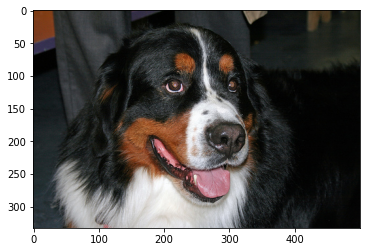

Dog! 
The image is a dog, the predicted breed is Bernese mountain dog

-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------



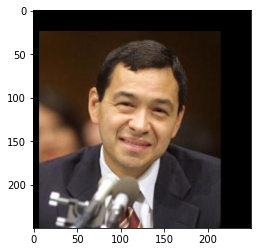

Human. 
 You look like a Bull terrier


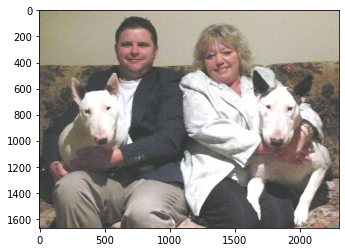


-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------



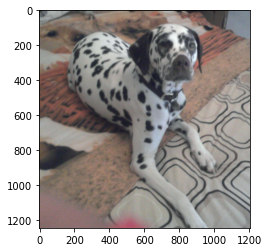

Dog! 
The image is a dog, the predicted breed is Dalmatian

-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------



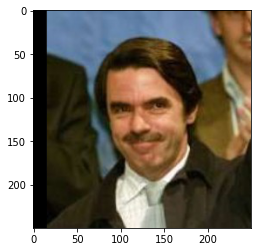

Human. 
 You look like a American water spaniel


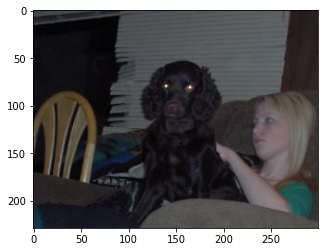


-----------------------------------------------------------
-----------------------------------------------------------
-----------------------------------------------------------



In [30]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.
from random import randrange

number_of_figure = 2

human_to_predict = [human_files[randrange(len(human_files))] for _ in range(number_of_figure)]

dog_test = np.array(glob("./dogImages/test/*/*"))
dog_to_predict = [dog_test[randrange(len(dog_test))] for _ in range(number_of_figure+1)]

for human, dog in zip(human_to_predict, dog_to_predict):
    run_app(VGG16, mtcnn, model_transfer, dog)
    run_app(VGG16, mtcnn, model_transfer, human, True)

# TODO test labrador different colors
# print("test labrador different color") 
# test labrador 
# labradors = ['images/Labrador_retriever_06457.jpg', 'images/Labrador_retriever_06455.jpg', 'images/Labrador_retriever_06449.jpg']
# for l in labradors:
#     run_app(VGG16, mtcnn, model_transfer, l)

#test extra input
# run_app('images/sample_cnn.png')